# Extended Data Fig. 4 (panels a-g)
- This experiment tests whether the fish HD neurons can track multiple visaul scenes. (**Fig. 2** in the *bioRxiv* version)
- The experiment starts with repeated presentations of flashes, followed by the presentation of the "sun-and-bars" scene, and then "stonehenge" scene
- This notebook generates data panels **Extended Data Fig. 4a-g**.
    - Panels are not in the order due to some shuffling during the editorial process -- sorry!
- Note that the results of bootstrap tests can very mildly fluctuate by the random number generator seed, which we did not fix in the reviewed version. The conclusions of all the analysis are robust to this fluctuation. 

In [1]:
# Import packages
from utility import *
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
from scipy.stats import binned_statistic, kstest, uniform
from scipy.signal import convolve2d
import json
import colorcet as cc

C:\Users\ryosuke\miniconda3\envs\hd_pub\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ryosuke\miniconda3\envs\hd_pub\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\ryosuke\miniconda3\envs\hd_pub\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# configure matplotlib
config_rcparams()

In [3]:
# parameters
R2_thresh = 0.15    # for finding cells whose activity can be well fit by sinusoids of the scene orientation
flash_thresh = 0.1  # for rejecting light responsive cells
n_heading_bin = 8   # we average HD neuron activity within 8 evenly spaced preferred orientaiton bins
n_offset_bin = 16   # for binning scene-bump offset, and fitting von Mises on it
n_bootstrap = 1000  # number of shuffles for bootstrap tests
mask_name = 'rhombomere1'

In [8]:
# get a list of fish
fish_list = get_fish_list('../data/ed04a', silent=True)
nested_list = nest_fish_list_per_fish(fish_list)

# Analysis
## Data extraction and ROI selection

In [9]:
data = []

# Go through all unique fish
for fish_id, recording_list in enumerate(nested_list):
    
    data.append([])
    
    # Go through all recordings
    for recording in recording_list:
        
        # Load the latest mask
        mask_list = list(recording.glob('mask_'+mask_name+'*'))
        with open(mask_list[-1], 'r') as f:
            mask = json.load(f)
        
        #################
        ### Load data ###
        #################

        # Load imaging & behavior data
        s2p_data, t_i, exp = load_data(recording, cells_only=False)

        # Pull out relevant variables from dict
        roi_coords = s2p_data['coords'] # for applying the anatomical mask
        slog = exp['stimulus']['log'] # list of dicts, each corresponding to an experimental epoch
        t_s = exp.stimulus_log['t'].to_numpy()  # stimulus timestamp

        # time trace of scene angle theta, and splitting it into exafference/reafference
        theta = exp.stimulus_log['cl2D_theta'].to_numpy()
        gtheta = exp.stimulus_log['cl2D_goal_theta'].to_numpy()
        ftheta = exp.stimulus_log['cl2D_fish_theta'].to_numpy() * exp.stimulus_log['cl2D_start_theta_update'].to_numpy()
        ftheta[np.isnan(ftheta)] = 0

        # downsampling
        theta_i = downsample_traces(t_s, theta, t_i)
        cumftheta_i = downsample_traces(t_s, np.cumsum(ftheta), t_i)
        extheta_i = downsample_traces(t_s, gtheta+np.cumsum(ftheta), t_i)
        
        # restrict rois by mask (do this before functional selection to reduce the time-consuming nonlinear curve fitting)
        in_mask = (roi_coords[:, 2] > mask['x0']) * (roi_coords[:, 2] < mask['x1']) * (roi_coords[:, 1] > mask['y0']) * (roi_coords[:, 1] < mask['y1'])
        traces = s2p_data['traces'][in_mask,:len(t_i)]
        roi_coords = roi_coords[in_mask, :]
        n_roi = traces.shape[0]

        # normalization and smoothing
        norm_traces = ((traces.T - np.median(traces, axis=1))/np.std(traces, axis=1)).T
        smoothed_traces = convolve2d(norm_traces, np.ones((1,5))/5, mode='same')
        
        #####################
        ### ROI selection ###
        #####################
        
        # Reject flash responsive cells
        flash_duration = slog[1]['duration']*2
        flash_t_start = [epoch['t_start'] for epoch in slog[1:-2:2]] # first epoch is wait, last two epochs are sun-and-bars and stonehenge. 
        flash_corr = calc_snip_correlation(norm_traces, t_i, flash_t_start, flash_duration)
        
        # Sinusoidal regression
        is_valid_theta = (np.isnan(theta_i)==False) * (t_i < slog[-1]['t_start'])
        fit_param, _, R2 = fit_transform_sinusoid(smoothed_traces[:, is_valid_theta], theta_i[is_valid_theta])
        
        # do the selection
        good_fit = (R2 > R2_thresh) * (flash_corr < flash_thresh)
        print(recording, 'Found', np.sum(good_fit), 'good ROIs out of', n_roi )
        
        # metadata for variability analysis
        metadata_dict = {'age': exp['general']['animal']['age'],
                         'n_roi_tot':traces.shape[0],
                         'hour':int(exp['general']['t_protocol_start'][11:13]),
                         'n_bout_tot':len(np.where(exp.stimulus_log['cl2D_start_theta_update'])[0])}
        
        ### Save everything in a dictionary ###
        D = {'stack': s2p_data['anatomy_stack'][0,:,:],
             'slog': slog,
             't_s': t_s,
             't_b': exp.behavior_log['t'].to_numpy(),
             'fish_theta': exp.stimulus_log['cl2D_fish_theta'].to_numpy(),
             'theta_update_spike': exp.stimulus_log['cl2D_start_theta_update'].to_numpy(),
             'tail_sum': exp.behavior_log['tail_sum'].to_numpy(),
             't_i': t_i,
             'theta_i': theta_i,
             'cumftheta_i': cumftheta_i,
             'extheta_i': extheta_i,
             'traces': smoothed_traces[good_fit, :],
             'fit_param': fit_param[good_fit,:],
             'coords': roi_coords[good_fit, :],
             'metadata':metadata_dict}
        data[-1].append(D)

..\data\ed04a\20231018_f0_p0_v05b8 Found 30 good ROIs out of 112
..\data\ed04a\20231018_f1_p0_v05b Found 5 good ROIs out of 103
..\data\ed04a\20231026_f0_86_5b Found 30 good ROIs out of 105
..\data\ed04a\20231026_f3_5b Found 17 good ROIs out of 99
..\data\ed04a\20231026_f4_5b Found 14 good ROIs out of 137
..\data\ed04a\20231026_f6_v5_copy Found 11 good ROIs out of 102
..\data\ed04a\20231105_f0_gad1b_aHB_z155_v5b Found 20 good ROIs out of 81
..\data\ed04a\20231105_f1_gad1b_aHB_z160_5b Found 58 good ROIs out of 101
..\data\ed04a\20231105_f3_gad1b_ahb_z200_5b_copy Found 2 good ROIs out of 149
..\data\ed04a\20231107_f0_gad1b_ahb_z265_v5b Found 19 good ROIs out of 169
..\data\ed04a\20231107_f1_gad1b_ahb_z191_v5b Found 21 good ROIs out of 151
..\data\ed04a\20231107_f2_gad1b_ahb_z236_v5b Found 20 good ROIs out of 148
..\data\ed04a\20231107_f3_gad1b_ahb_z180_v5b Found 6 good ROIs out of 143
..\data\ed04a\20231108_f0_gad1b_ahb_z310_v5b Found 64 good ROIs out of 145
..\data\ed04a\20231108_f1_gad

## Additional preprocessing
- Calculate bump phase
- Reject fish with less than 4 bins

In [10]:
bad_recs = []
for i, fish_data in enumerate(data):
    for j, D in enumerate(fish_data):
        # Bump phase calculation
        pva_theta, pva_length, binned_traces, _, _ = calc_binned_pva(D['traces'], D['fit_param'][:,1], n_bin=n_heading_bin)

        # empty bin check
        n_empty_bins = np.sum(np.isnan(binned_traces[:,0]))
        
        if n_empty_bins < 5:        
            data[i][j]['pva_theta'] = pva_theta
            data[i][j]['pva_length'] = pva_length
            data[i][j]['binned_traces'] = binned_traces
        else:
            bad_recs.append((i,j))

# pop bad recs from big ones
for i, j in bad_recs[::-1]:
    data[i].pop(j)
data = [fish for fish in data if fish]

## Offset histogram calculation & Bootstrap testing
- Bin scene-bump offset into evenly spaced bins
- fit von Mises distributions
- This takes few minutes (on my setup, each fish takes 6 seconds)

In [11]:
# prepare bins
offset_bin_edges = np.linspace(-np.pi, np.pi, n_offset_bin+1)
offset_bin_center = (offset_bin_edges[:-1] + offset_bin_edges[1:])/2

for i, fish_data in enumerate(data):
    for j, D in enumerate(fish_data):
        
        # Fit von Mises distribution to the offset between the bump and scene orientation
        # during the stonehenge epoch
        bump_scene_offset = angular_diff(D['theta_i'], D['pva_theta'])
        is_stonehenge = D['t_i']>D['slog'][-1]['t_start']
        bso_hist = np.histogram(bump_scene_offset[is_stonehenge], bins=offset_bin_edges, density=True)[0]
        fit, _ = curve_fit(von_Mises, offset_bin_center, bso_hist, bounds=([-np.pi,0], [np.pi,np.inf]))

        shuffle_kappa = np.zeros(n_bootstrap)
        for b in tqdm(range(n_bootstrap)):
            # shift theta and bump by a random amount, recalculate offset, fit von Mises again
            shuffled_offset = angular_diff(D['theta_i'][is_stonehenge], np.roll(D['pva_theta'][is_stonehenge], np.random.randint(np.sum(is_stonehenge))))
            shuffled_hist = np.histogram(shuffled_offset, bins=offset_bin_edges, density=True)[0]
            shuffled_fit, _ = curve_fit(von_Mises, offset_bin_center, shuffled_hist, bounds=([-np.pi,0], [np.pi,np.inf]))
            shuffle_kappa[b] = shuffled_fit[1]
            
        data[i][j]['offset_hist'] = bso_hist
        data[i][j]['fit_mu'] = fit[0]
        data[i][j]['fit_kappa'] = fit[1]
        data[i][j]['bs_med_kappa'] = np.median(shuffle_kappa)
        data[i][j]['bs_95pt_kappa'] = np.percentile(shuffle_kappa, 95)
        data[i][j]['p_kappa'] = np.mean(shuffle_kappa > fit[1])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.88it/s]


# Panels
## Extended Data Fig. 4b (individual example of behavioral and neural time traces)

In [12]:
# pick an example fish
fid = 2
rid = 0
D = data[fid][rid]

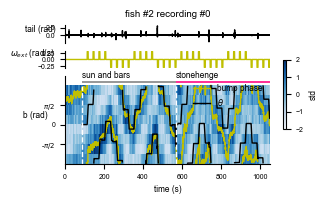

In [13]:
fig, ax = plt.subplots(3, 1, figsize=(3.3,1.8), height_ratios=(1,1,5))

## Behavioral time trace
ax[0].plot(D['t_b'], D['tail_sum'], label='tail sum', lw=1, color='black')
ax[0].set_title('fish #{0} recording #{1}'.format(fid,rid))
ax[0].set_ylabel('tail (rad)', rotation=0)
toggle_spines(ax[0],0,0,0,1)

## visualize external rotation of the scene
t_start = D['slog'][-2]['t_start']
t_stonehenge = D['slog'][-1]['t_start']
t_end = max(D['t_i'])

OL_on = (((D['t_i']-t_start)%30)>25) * (D['t_i']>t_start)
OL_sign = 1-2*(((D['t_i']-t_start)%240)>120)
ax[1].plot(D['t_i'], OL_on*OL_sign*18/180*np.pi,'y-')
ax[1].set_ylabel(r'$\omega_{ext}$ (rad/s)',rotation=0)
toggle_spines(ax[1],0,0,0,1)

## Neural time trace
im = ax[2].imshow(D['binned_traces'][::-1, :], aspect='auto', interpolation='nearest', vmax=2, vmin=-2, extent=(0, max(D['t_i']), -np.pi, np.pi), cmap='Blues')
ax[2].plot(D['t_i'], wrapped(np.unwrap(D['pva_theta']), offset=np.pi), 'y-', linewidth=1, label='bump phase')
ax[2].plot(D['t_i'], wrapped(D['theta_i'], offset=np.pi), 'k-', linewidth=1, label=r'$\theta$')
ax[2].legend()
ax[2].plot((t_start,t_start),(-np.pi,np.pi),'w--')
ax[2].plot((t_stonehenge,t_stonehenge),(-np.pi,np.pi),'w--')

# indicate different scenes
ax[2].fill_between((t_start, t_stonehenge), (np.pi+0.2, np.pi+0.2), (np.pi+0.4, np.pi+0.4), facecolor=color_getter(1), edgecolor='none')
ax[2].text(t_start, np.pi+0.6, 'sun and bars')
ax[2].fill_between((t_stonehenge, t_end), (np.pi+0.2, np.pi+0.2), (np.pi+0.4, np.pi+0.4), facecolor=color_getter(0), edgecolor='none')
ax[2].text(t_stonehenge, np.pi+0.6, 'stonehenge')

ax[2].set_yticks([-np.pi/2, 0, np.pi/2])
ax[2].set_yticklabels((r'-$\pi/2$', '0', r'$\pi/2$'))
ax[2].set_ylabel('b (rad)', rotation=0)
ax[2].set_xlabel('time (s)')
cb = plt.colorbar(im, ax=ax, shrink=0.5)
cb.set_label('std')

toggle_spines(ax[2],0,1,0,1)
for axx in ax:
    axx.set_xlim(0, t_end)

plt.savefig('../svg/ed04_b.svg')
plt.show()

## Extended Data Fig. 4c (example scene-bump offset histogram)

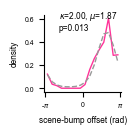

In [15]:
# show histogram with fit
fig, ax = plt.subplots(1, 1, figsize=(1,1))

ax.plot(offset_bin_center, D['offset_hist'], color=color_getter(0)) # data
ax.plot(offset_bin_center, von_Mises(offset_bin_center, D['fit_mu'], D['fit_kappa']), ls='--', color=color_getter(1)) # fit

# label & axis management
ax.text(-2, 0.5, '$\kappa$={:0.2f}, $\mu$={:0.2f}\np={:0.3f}'.format( D['fit_mu'], D['fit_kappa'], D['p_kappa']))
ax.set_xticks([-np.pi, 0, np.pi])
ax.set_xticklabels((r'-$\pi$', '0', r'$\pi$'))
ax.set_xlabel('scene-bump offset (rad)')
ax.set_ylabel('density')
toggle_spines(ax, 0, 1, 0, 1)

plt.savefig('../svg/ed04_c.svg')
plt.show()

## Extended Data Fig. 4d, e (von Mises $\kappa$ and $\mu$ for all fish, with boostrap $\kappa$ distributions)
- It so happens that we only have one recording per fish (so actually we did not need to do the nesting)

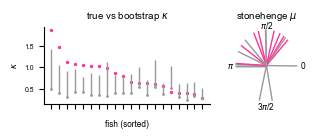

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(3.3,1), width_ratios=(5,2))

# Prepare bootstrap result
fit_kappa     = np.asarray([temp[0]['fit_kappa'] for temp in data])
fit_mu     = np.asarray([temp[0]['fit_mu'] for temp in data])
bs_med_kappa  = np.asarray([temp[0]['bs_med_kappa'] for temp in data])
bs_95pt_kappa = np.asarray([temp[0]['bs_95pt_kappa'] for temp in data])
p_kappa       = np.asarray([temp[0]['p_kappa'] for temp in data])
fish_sort_ind = np.argsort(np.argsort(-fit_kappa))

# data kappa
ax[0].scatter(fish_sort_ind, fit_kappa, s=2, color=color_getter(0))

# bootstrap kappa
ax[0].errorbar(fish_sort_ind, bs_med_kappa, np.vstack((0*bs_med_kappa, bs_95pt_kappa-bs_med_kappa)),
               marker='.', color=color_getter(1), ls='none', markersize=2)

# axis management
ax[0].set_xticks(range(len(p_kappa)))
ax[0].set_xticklabels([])
ax[0].set_xlabel('fish (sorted)')
ax[0].set_ylabel('$\kappa$')
ax[0].set_title('true vs bootstrap $\kappa$')
toggle_spines(ax[0], 0, 1, 0, 1)

# Mu distribution as vector
for p, mu in zip(p_kappa, fit_mu):
    ax[1].plot((0,np.cos(mu)),(0,np.sin(mu)), color=color_getter(int(p>0.05)))
ax[1].text(1.3,0,'0', verticalalignment='center', horizontalalignment='right')
ax[1].text(0,1.3,r'$\pi$/2', verticalalignment='top', horizontalalignment='center')    
ax[1].text(-1.3,0,r'$\pi$', verticalalignment='center', horizontalalignment='left')    
ax[1].text(0,-1.3,r'3$\pi$/2', verticalalignment='bottom', horizontalalignment='center')    

ax[1].set_title('stonehenge $\mu$')
toggle_spines(ax[1], 0, 0, 0, 0)

plt.savefig('../svg/ed04_de.svg')
plt.show()

## Extended Data Fig. 4f
- This is logically more related to Panel b, but because we moved panels a-d to the Extended Data at the final editing phase, things are ordered a bit strangely

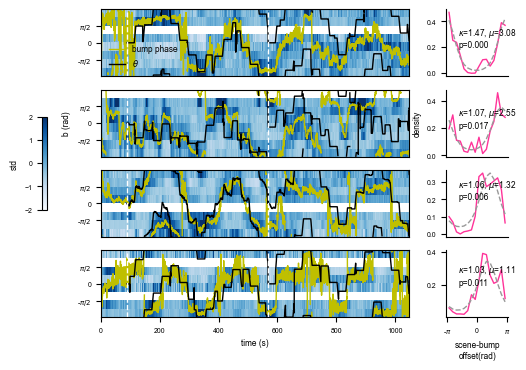

In [19]:
# Example fish to look at
ids = (17, 7, 16, 13)

fig, ax = plt.subplots(len(ids), 2, figsize=(7, 1 * len(ids)), width_ratios=(5,1))
k = 0
for fid, axx in zip(ids, ax):
    # get data for this fish
    D = data[fid][0]
    t_start = D['slog'][-2]['t_start']
    t_stonehenge = D['slog'][-1]['t_start']
    
    # traces
    im = axx[0].imshow(D['binned_traces'][::-1, :], aspect='auto', interpolation='nearest', vmax=2, vmin=-2, extent=(0, max(D['t_i']), -np.pi, np.pi), cmap='Blues')
    axx[0].plot(D['t_i'], wrapped(np.unwrap(D['pva_theta']), offset=np.pi), 'y-', linewidth=1, label='bump phase')
    axx[0].plot(D['t_i'], wrapped(D['theta_i'], offset=np.pi), 'k-', linewidth=1, label=r'$\theta$')
    axx[0].plot((t_start,t_start),(-np.pi,np.pi),'w--')
    axx[0].plot((t_stonehenge,t_stonehenge),(-np.pi,np.pi),'w--')
    axx[0].set_yticks([-np.pi/2, 0, np.pi/2])
    axx[0].set_yticklabels((r'-$\pi/2$', '0', r'$\pi/2$'))
    
    # histogram with fits
    axx[1].plot(offset_bin_center, D['offset_hist'], color=color_getter(0))
    axx[1].plot(offset_bin_center, von_Mises(offset_bin_center, D['fit_mu'], D['fit_kappa']), ls='--', color=color_getter(1))
    axx[1].text(-2, 0.2, '$\kappa$={:0.2f}, $\mu$={:0.2f}\np={:0.3f}'.format(fit_kappa[fid],fit_mu[fid],p_kappa[fid]))
    
    k=k+1
    
cb = plt.colorbar(im, ax=ax, shrink=0.3, location='left')
cb.set_label('std')

ax[0,0].legend()
ax[1, 0].set_ylabel('b (rad)')
ax[1, 1].set_ylabel('density')
ax[-1, 0].set_xlabel('time (s)')
ax[-1, 1].set_xlabel('scene-bump\noffset(rad)')
ax[-1,1].set_xticks([-np.pi, 0, np.pi])
ax[-1,1].set_xticklabels((r'-$\pi$', '0', r'$\pi$'))

# cosmetics
for i, axx in enumerate(ax):
    toggle_spines(axx[1],0,1,0,1)
    if i<len(ids)-1:
        axx[0].set_xticks([])
        axx[1].set_xticks([])

plt.savefig('../svg/ed04_f.svg')
plt.show()

## Extended Data Fig. 4g (Cumulative distribution of bootstrap p values)

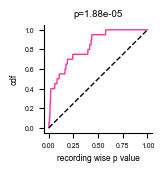

In [21]:
# calculate p-value cdf
flattened_p = [max(x, 1/n_bootstrap) for x in p_kappa]
p_x = np.linspace(0,1,1000)
p_cdf = np.asarray([np.mean(flattened_p<x) for x in p_x])

fig, ax = plt.subplots(1,1,figsize=(1.4, 1.4))
ax.plot(p_x, p_cdf, color=color_getter(0))
ax.plot((0,1), (0,1), 'k--')

ax.set_xlabel('recording wise p value')
ax.set_ylabel('cdf')
ax.set_title('p={:0.2e}'.format(kstest(flattened_p, uniform.cdf)[1])) # exact numbers can vary!
toggle_spines(ax, 0, 1, 0, 1)

plt.savefig('../svg/ed04_g.svg')
plt.show()

## Extended Data Fig. 1i (covariance of neural data with nuisance vairables)

In [22]:
# disregard nesting (for the sake of simplicity)

ages = []
hours = []
n_rois = []
n_bouts = []
    
for rec in data:
    for D in rec:
        ages.append(D['metadata']['age'])
        hours.append(D['metadata']['hour'])
        n_rois.append(D['metadata']['n_roi_tot'])
        n_bouts.append(D['metadata']['n_bout_tot'])

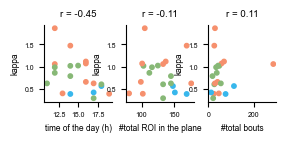

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(3,1))

ax[0].scatter(hours, fit_kappa, c=ages, s=10, cmap=cc.cm.CET_I1)
ax[0].set_xlabel('time of the day (h)')
ax[0].set_title('r = {:0.2f}'.format(np.corrcoef(hours, fit_kappa)[0,1]))

ax[1].scatter(n_rois, fit_kappa, c=ages, s=10, cmap=cc.cm.CET_I1)
ax[1].set_xlabel('#total ROI in the plane')
ax[1].set_title('r = {:0.2f}'.format(np.corrcoef(n_rois, fit_kappa)[0,1]))

ax[2].scatter(n_bouts, fit_kappa, c=ages, s=10, cmap=cc.cm.CET_I1)
ax[2].set_xlabel('#total bouts')
ax[2].set_title('r = {:0.2f}'.format(np.corrcoef(n_bouts, fit_kappa)[0,1]))

for axx in ax:
    toggle_spines(axx, 0, 1, 0, 1)
    axx.set_ylabel('kappa')
    
plt.savefig('../svg/ed01_i.svg')
plt.show()

## Extended Data Fig. 1c (Fish turning around exogenous rotation)
- Show that fish is doing OMR and not fixating on the sun or bars

In [24]:
# Cut out snippets of exafferent rotation & cumulative turns

mean_snips = []

for i, fish_data in enumerate(data):
    
    this_fish_theta_snips = []
    this_fish_cumftheta_snips = []
    this_fish_extheta_snips = []
    
    D = fish_data[0] # using the fact that this experiment was never repeated twice in the same fish
    
    mean_snips.append([[],[]])
    for k in (-2, -1): # for sun and bars / stonehenge
        # find midpoints of exafferent rotations
        t_start = D['slog'][k]['t_start']
        duration = D['slog'][k]['duration']
        olp = D['slog'][k]['OLperiod']
        old = D['slog'][k]['OLduration']

        rotation_midpoints = [t_start + i*olp + (olp - old/2) for i in range(duration//olp-1)]

        theta_snip, snip_t = cut_snip(D['theta_i'],     D['t_i'], rotation_midpoints, 10, 10, subtract_pre=False)
        cumftheta_snip, _  = cut_snip(D['cumftheta_i'], D['t_i'], rotation_midpoints, 10, 10, subtract_pre=False)
        extheta_snip, _    = cut_snip(D['extheta_i'],   D['t_i'], rotation_midpoints, 10, 10, subtract_pre=False)

        theta_snip     -= theta_snip[:, 0][:, None]
        cumftheta_snip -= cumftheta_snip[:, 0][:, None]
        extheta_snip   -= extheta_snip[:, 0][:, None]

        # flipping 
        theta_snip     *= np.sign(extheta_snip[:, -1])[:, None]
        cumftheta_snip *= np.sign(extheta_snip[:, -1])[:, None]
        extheta_snip   *=np.sign(extheta_snip[:, -1])[:, None]
        
        # averaging over trials & registering
        mean_snips[-1][k] = (
            np.mean(theta_snip, axis=0),
            np.mean(cumftheta_snip, axis=0),
            np.mean(extheta_snip, axis=0)
        )
    
mean_snips = np.asarray(mean_snips)

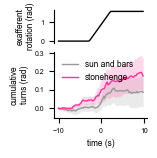

In [25]:
fig, ax = plt.subplots(2, 1, figsize=(1.2, 1.4), height_ratios=(1,2))

pop_mean_snips = np.mean(mean_snips, axis=0)
pop_sem_snips  = np.std(mean_snips, axis=0) / np.sqrt(mean_snips.shape[0])

# visualize stimulus
ax[0].plot(snip_t, pop_mean_snips[0, 2, :], color='black')

# visualize turning
for i, label in enumerate(('sun and bars', 'stonehenge')):
    ax[1].fill_between(snip_t,
                       pop_mean_snips[i, 1, :]-pop_sem_snips[i, 1, :],
                       pop_mean_snips[i, 1, :]+pop_sem_snips[i, 1, :],
                       alpha=0.2, color=color_getter(1-i), lw=0)
    ax[1].plot(snip_t, pop_mean_snips[i, 1, :], color=color_getter(1-i),label=label)
ax[1].legend()
ax[0].set_ylabel('exafferent\nrotation (rad)')
ax[1].set_ylabel('cumulative\nturns (rad)')
ax[1].set_xlabel('time (s)')

toggle_spines(ax[0], 0,0,0,1)
toggle_spines(ax[1], 0,1,0,1)

plt.savefig('../svg/ed01_c.svg')
plt.show()

## Extended Data Fig. 1d (bout bias as a function of scene orientation)

In [26]:
# pull out bias of each bout and associated scene orientation

bias_theta = []

for i, fish_data in enumerate(data):
    D = fish_data[0]
    
    bout_frame = np.where(D['theta_update_spike']==1)[0]
    bout_t = D['t_s'][bout_frame]
    bout_bias = D['fish_theta'][bout_frame]

    this_fish_bias_theta = []
    for k in (-2, -1):
        t_start = D['slog'][k]['t_start']
        t_end = t_start + D['slog'][k]['duration']
        bias_stim_on = bout_bias[(bout_t>t_start)*(bout_t<t_end)]

        # get theta
        bout_frame_i = np.asarray([np.argmax(D['t_i']>tt) for tt in bout_t if tt>t_start and tt<t_end])
        theta_at_bout = D['theta_i'][bout_frame_i]
        this_fish_bias_theta.append(np.vstack((bias_stim_on, theta_at_bout)))
        
    bias_theta.append(this_fish_bias_theta) # fish x condition x bouts
        

In [27]:
# calculate average turn bias for each epoch binned by scene orientation
# also calculate marginal distributions 
# separately for the two epochs

be = np.linspace(-np.pi,np.pi,13) # prepare bin edges
bc = (be[1:]+be[:-1])/2

mean_bias_by_theta =  np.asarray(
    [[binned_statistic(angular_diff(bt[1,:],0),bt[0,:],bins=be)[0] for bt in temp] for temp in bias_theta]
) # now this is fish x condition x bins

mean_mbbt = np.nanmean(mean_bias_by_theta, axis=0) # condition x bins
sem_mbbt = np.nanstd(mean_bias_by_theta, axis=0) / np.sqrt(len(data))

theta_hist = np.asarray(
    [[np.histogram(angular_diff(bt[1,:],0), bins=be, density=True)[0] for bt in temp] for temp in bias_theta]
)
bias_hist = np.asarray(
    [[np.histogram(bt[0,:], bins=np.linspace(-5,5,20), density=True)[0] for bt in temp] for temp in bias_theta]
)

mean_th = np.nanmean(theta_hist,axis=0)
sem_th = np.nanstd(theta_hist,axis=0)/np.sqrt(len(data))
mean_bh = np.nanmean(bias_hist,axis=0)
sem_bh = np.nanstd(bias_hist,axis=0)/np.sqrt(len(data))

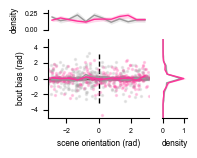

In [28]:
# visualization

fig, ax = plt.subplots(2, 2, width_ratios=(4,1), height_ratios=(1,4), figsize=(1.8,1.4))

# plot bout / theta pairs as scatter plots
for i, this_btpair in enumerate(bias_theta):
    ax[1, 0].scatter(angular_diff(this_btpair[0][1, :],0), this_btpair[0][0, :], s=2, alpha=0.2, color=color_getter(1)) # sun and bars
    ax[1, 0].scatter(angular_diff(this_btpair[1][1, :],0), this_btpair[1][0, :], s=2, alpha=0.2, color=color_getter(0)) # stonehenge

# plot fish-averaged margnial distributions
for k in range(2):
    ax[1, 0].fill_between(bc, mean_mbbt[k]-sem_mbbt[k], mean_mbbt[k]+sem_mbbt[k], color=color_getter(1-k), alpha=0.2, lw=0)
    ax[1, 0].plot(bc, mean_mbbt[k], color=color_getter(1-k))
    ax[0, 0].fill_between(bc, mean_th[k]-sem_th[k], mean_th[k]+sem_th[k], alpha=0.2, color=color_getter(1-k), lw=0)
    ax[0, 0].plot(bc, mean_th[k], color=color_getter(1-k))
    ax[1, 1].fill_betweenx(np.linspace(-5,5,19), mean_bh[k]-sem_bh[k], mean_bh[k]+sem_bh[k], alpha=0.2, color=color_getter(1-k), lw=0)
    ax[1, 1].plot(mean_bh[k], np.linspace(-5,5,19), color=color_getter(1-k))

    
# guides
ax[1, 0].plot((-np.pi,np.pi),(0,0),'k--',zorder=-3)
ax[1, 0].plot((0,0),(-np.pi,np.pi),'k--',zorder=-3)
ax[0, 0].set_ylim(0,0.3)

for i in range(2):
    ax[i, 0].set_xlim(-np.pi, np.pi)
    ax[1, i].set_ylim(-5, 5)

ax[0, 0].set_ylabel('density')
ax[1, 0].set_ylabel('bout bias (rad)')
ax[1, 0].set_xlabel('scene orientation (rad)')
ax[1, 1].set_xlabel('density')
    
toggle_spines(ax[0,0], 0, 0, 0, 1)
toggle_spines(ax[1,0], 0, 1, 0, 1)
toggle_spines(ax[0,1], 0, 0, 0, 0)
toggle_spines(ax[1,1], 0, 1, 0, 0)

plt.savefig('../svg/ed01_d.svg')
plt.show()